In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as pyplotcolors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import sktensor as skt
from scipy.sparse.linalg import svds

import time
%matplotlib inline

In [2]:
import tools
reload(tools)
from tools import *

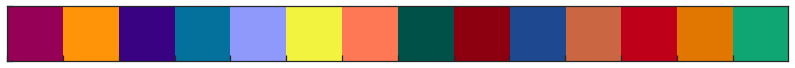

In [3]:
import seaborn as sns
import itertools
# plt.rc('text', usetex=True)
sns.set()
sns.set_style("white")
# sns.set(font_scale=1., 
#         rc={'text.usetex' : True,
#             'font.size' : 32})

sns.set(font_scale=1.8)
sty = sns.set_style("ticks",{"xtick.major.size":0.8,"ytick.major.size":0.8,
                             "xtick.direction": "in","ytick.direction": "in"})
# sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

# plt.rcParams.update({'mathtext.fontset' : 'stix'})
plt.rcParams.update({
    'font.family' : 'serif',
    'text.usetex' : True
    })
#     'legend.fontsize' : 10,
#     'font.size' : 11,
#     'axes.titlesize' : 11,
#     'axes.labelsize' : 11,

# Some more useful parameters at
#
# https://seaborn.pydata.org/tutorial/aesthetics.html
#
# Some colours:
# burgandy : (0.44655508845679537, 0.2211960285890096, 0.30515631911836943)

xkcdcolors = [
"dark magenta",
"tangerine",
"indigo",
"ocean blue",
"periwinkle blue",
"off yellow",
"melon",
"dark blue green",
"crimson",
"cobalt",
"terracotta",
"scarlet",
"pumpkin",
"bluish green",
"slate green",
"twilight blue",
"saffron",
"kiwi green"
]

npal = 14
shift = 0
stride = 1
start = 0
rot = 8.0
gamma = 1.0
dark = 0.1
light = 0.8
# palnamething = sns.cubehelix_palette(npal,start=start,rot=rot,light=light,dark=dark,reverse=True, gamma=gamma)
# palnamething = sns.color_palette("Paired")
# palnamething = sns.color_palette("bright")
palnamething = sns.color_palette(sns.xkcd_palette(xkcdcolors))

sns.set_palette(palnamething, npal)
pal = sns.color_palette(palnamething, npal)
palette = itertools.cycle(pal)
sns.palplot(pal)

for _ in range(shift):
    next(palette)
coldict = {}
for i in range(npal):
    for s in range(1,stride):
        next(palette)
    coldict.update({i:next(palette)})

In [4]:
# PCA params
#
latticemode = True
use_scaling = True # You should always use scaling 
use_xyth = False
use_quadrature = False
quad_dims = [[1,3],[2,4]]
# quad_dims = [[1,2],[3,5],[4,6],[7,8]]
# For polar2, it seems that [3,5] might actually be pairs

In [155]:
# hyperparams
methods = ["random","WD","WA"]
nmethod = len(methods)
n_nbr = 36
nx = 28
nft = n_nbr*2 if use_xyth else n_nbr
run = "e3defect"
method = methods[1]

source = "/home/walterms/mcmd/nn/data/pca/"
fname = ""
if latticemode:
    prestr = source+"lat_nbrs_"+run
    if use_xyth: prestr+="_xyth"
    fname = prestr+"_"+str(n_nbr)+"_"+str(method)
else:
    prestr = source+"nbrs_"+run
    if use_xyth: prestr+="_xyth"
    fname = source+"nbrs_"+run+"_"+str(n_nbr)+"_"+str(method)

In [156]:
import tools
reload(tools)
from tools import *

with open(fname) as f:
    for li, l in enumerate(f):
        pass
nsample = li + 1

wx, wy = 0,1


X = np.empty((nsample,nft))
with open(fname) as fin:
    for i, l in enumerate(fin):
        vals = [float(x) for x in l.split()] #l.split ignores the newline
        X[i] = vals

if use_scaling:
    SS = StandardScaler()
    X = SS.fit_transform(X)

K = 10 # number reduced dimensions
pca = PCA(n_components=K)
Y = pca.fit_transform(X)
# Y_ = pca.inverse_transform(Y)
if use_quadrature:
    Y = quad_features(Y,quad_dims)
    for pair in quad_dims:
        if pair[0] != pair[1]: K-=1

Text(0.05,0.9,u'(d)')

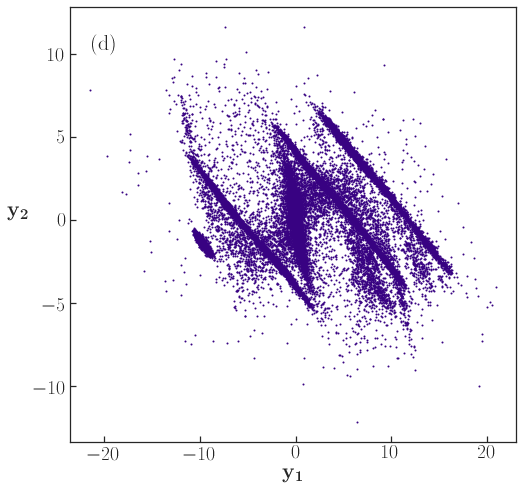

In [94]:
mev = 5
fig = plt.figure(figsize=(8,8))
grid = plt.GridSpec(1,1)
scatt = fig.add_subplot(grid[0])
_ = scatt.scatter(Y[::mev, wx],Y[::mev, wy],s=1,c=coldict[2])
# plt.colorbar(_,ax=ax[0])
scatt.set_xlabel(r'$\mathbf{y_%d}$'%(wx+1))
scatt.set_ylabel(r'$\mathbf{y_%d}$'%((wy+1)),rotation="horizontal",labelpad=15)

scatt.text(0.05,0.9,'(d)',
    transform=scatt.transAxes)

In [95]:
# Colouring method
#
use_kmeans = False
use_dims = False # color by first 3 dims
use_1D = True
Dim = 0 # 0 is first dim

In [203]:
seed = 1235678
B = 0.32 # location of min sat thresh in units of max
B_ = 0.6 # location of max sat thresh
Rfac = 0.
Gfac = 0.99
Bfac = 0.99

# For dim coloring
maxsats = np.max(Y[:,:3],axis=0) - np.min(Y[:,:3],axis=0)
minsats = np.min(Y[:,:3],axis=0)

base_colors = np.zeros((nsample,3))

maxsat, minsat = maxsats[Dim], minsats[Dim]
P = Y[:,Dim]
P = np.subtract(P,minsat)
P = np.subtract(P,B*maxsat)
P = np.divide(P,B_*(1-B)*maxsat)
P = np.where(P>1.,1.,P)
P = np.where(P<0,0.,P)

base_colors[:,0] = np.ones(nsample)*Rfac
base_colors[:,1] = (1-P.copy())*Gfac
base_colors[:,2] = (P.copy())*Bfac

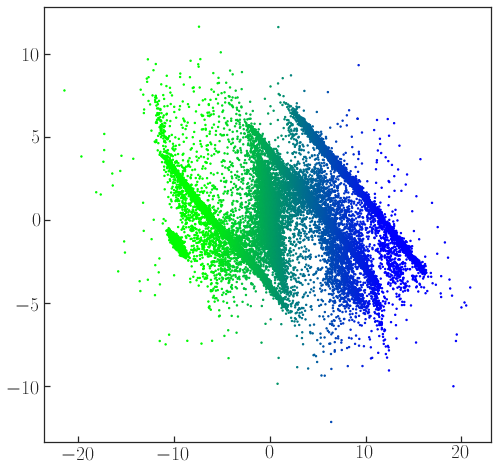

In [204]:
f,ax = plt.subplots(1,1,figsize=(8,8))
_ = ax.scatter(Y[::mev,0],Y[::mev,1],s=2,c=base_colors[::mev]) # for kmeans
if use_kmeans:
    _ = ax.scatter(cntr[:,0],cntr[:,1],marker='x',s=200,c="k",linewidth=4.0)
# _ = ax.set_aspect("equal")

In [205]:
def get_probecolors(y_d,maxsat,minsat):
    # y_d is the pca_feats[:,Dim]
    probecolors_ = np.zeros((nx*nx,3))
    P = y_d.copy()
    P = np.subtract(P,minsat)
    P = np.subtract(P,B*maxsat)
    P = np.divide(P,B_*(1-B)*maxsat)
    P = np.where(P>1.,1.,P)
    P = np.where(P<0.,0.,P)

    probecolors_[:,2] = (P.copy())*Bfac
    probecolors_[:,1] = (1-P.copy())*Gfac
    probecolors_[:,0] = np.ones(nx*nx)*Rfac
    
    return probecolors_

In [209]:
#
# Grab rods from unlbl file
# unlbl files have rod ranges [-0.5,0.5], [-0.5,0.5], [0,1.0]
#
import tools
reload(tools)
from tools import *

edge = 15. # 15 for bigbox1, 10 for bigbox2
run = "bigbox_vid"
fname = "/home/walterms/mcmd/nn/data/unlbl/"+run # 60**2 rods for both bigboxes
nrod = 60**2
nprobe = nx**2
L = 1.0

snaps = np.arange(200,700,2) # 200 is good start
nsnap = len(snaps)
nblskip = snaps[0]

In [210]:
nbl = 0
irod = 0
isnap = 0
rods = np.empty(shape=(nrod,3))
probes = gen_probes(nx, edge)

probecolors = np.zeros((nsnap,nprobe,3))
pltrods = np.zeros((nsnap,nrod,3))

beg_ts = time.time()
with open(fname) as fin:
    for i, l in enumerate(fin):
        if nbl < nblskip:
            if l == "\n":
                nbl += 1
            continue
        if nbl not in snaps:
            if l == "\n":
                nbl += 1
            continue
        if l == "\n":
            # Done block
            features = None
            features, nbr_coords_full, alphas = get_lat_nbrs(rods,n_nbr,edge,nx,probes,method=method,use_xyth=use_xyth,ret_nbrs=True)
            features_raw = features.copy()
            features = SS.transform(features) # standardize from training set

            pca_feats = pca.transform(features) # reduce dimensions with pca
            if use_quadrature:
                pca_feats = quad_features(pca_feats,quad_dims)
            
            probecolors[isnap] = get_probecolors(pca_feats[:,Dim],maxsats[Dim],minsats[Dim])
            pltrods[isnap] = rods.copy()
            
            if nbl == snaps[-1]:
                break
            rods = np.empty(shape=(nrod,3))
            irod = 0
            nbl += 1        
            isnap += 1
            continue

        if l.startswith("label"): continue
        rod = [float(x) for x in l.split()]
        x,y = edge*rod[0], edge*rod[1]
        th = (myrotate(twopi*rod[2]))%twopi

        rods[irod] = [x, y, th]
        irod += 1

end_ts = time.time() 
print("Done\nelapsed time: %f" % (end_ts - beg_ts))


Done
elapsed time: 473.374671


100 seconds for snaps = (0,4000,100)

Done Animation
snap 0
snap 0
snap 12
snap 24
snap 36
snap 48
snap 60
snap 72
snap 84
snap 96
snap 108
snap 120
snap 132
snap 144
snap 156
snap 168
snap 180
snap 192
snap 204
snap 216
snap 228
snap 240
snap 0
snap 0
snap 12
snap 24
snap 36
snap 48
snap 60
snap 72
snap 84
snap 96
snap 108
snap 120
snap 132
snap 144
snap 156
snap 168
snap 180
snap 192
snap 204
snap 216
snap 228
snap 240


/home/walterms/jupyter_py2/lib/python2.7/site-packages/matplotlib/animation.py:1425: UserWarning: Animation movie is 28846847 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).
  embed_limit))


snap 0


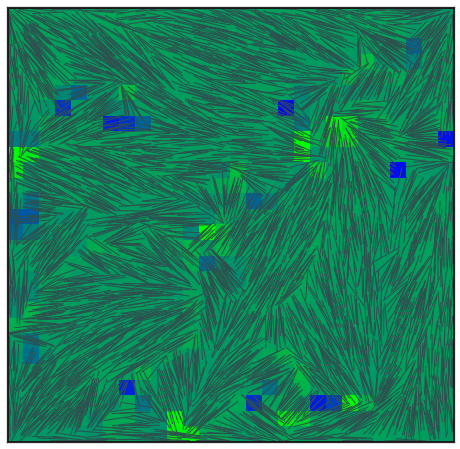

In [211]:
from matplotlib import animation, rc
from IPython.display import HTML

# Probe image
f, ax = plt.subplots(1,1,figsize=(8,8))
radius = 0.5*edge
boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2,linewidth=3);
ax.add_artist(boundary);
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlim(-radius,radius)
# ax.set_ylim(-radius,radius)
ax.set_aspect("equal")

nimg = nsnap
ims = []
mods = nimg//20
if mods == 0: mods = 1


lines = []
nrodplot = nrod
for _ in range(nrodplot):
    l, = ax.plot([],[],c="darkslategrey",linewidth=1,linestyle='-')
    lines.append(l)

imgstuff = ax.imshow(probecolors[0].reshape((nx,nx,3)),aspect='auto',extent=(-edge/2,edge/2,-edge/2,edge/2))
# lines.append(imgstuff)

# linee, = ax.plot([],[],c="darkslategrey",linewidth=1,linestyle='-')
# linee.set_data([[],[]])

def initplts():
    ax.add_artist(boundary);
    linee.set_data([],[])
#     imgstuff.set_data([[],[]])
    return linee,

def animateplts(s):
    if s%mods==0: print "snap",s
    for i,r in enumerate(pltrods[s][:nrodplot]):
        th = r[2]
        x1 = r[0] - 0.5*cos(th)
        x2 = r[0] + 0.5*cos(th)
        y1 = r[1] - 0.5*sin(th)
        y2 = r[1] + 0.5*sin(th)
        
        lines[i].set_data([x1,x2],[y1,y2])

#     linee.set_data([x1,x2],[y1,y2])
    
    imgstuff.set_data(probecolors[s].reshape((nx,nx,3)))
#     ax.set_title(r'$edge = {}, \rho = {}$'.format(edges[s,0],edges[s,1]))
    return lines,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(f, animateplts, frames=nimg, interval=1000, 
                               blit=False, repeat_delay=3000)

    
print "Done Animation"
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('vids/bigbox_vid.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

# plt.show()
HTML(anim.to_html5_video())

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

# Probe image
f, ax = plt.subplots(1,1,figsize=(8,8))
radius = 0.5*edge
boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2,linewidth=3);
ax.add_artist(boundary);
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

nimg = 10
ims = []
mods = nimg//20
if mods == 0: mods = 1


for s in np.arange(nimg):
    beg_ts = time.time()
    if s%mods == 0:
        print "snap ",s
#     print len(ax.get_lines())
    probeimg = probecolors[s].reshape((nx,nx,3))
    # Rods
    lines = []
    for i,r in enumerate(pltrods[s][:1000]):
#         plotrods([rod],ax,col="darkslategrey",lw=1.)
        th = r[2]
        x1 = r[0] - 0.5*cos(th)
        x2 = r[0] + 0.5*cos(th)
        y1 = r[1] - 0.5*sin(th)
        y2 = r[1] + 0.5*sin(th)
        l, = ax.plot([x1, x2], [y1, y2], color="darkslategrey", linestyle='-', linewidth=1.,animated=True);
        lines.append(l)
    imgcol = ax.imshow(probeimg,aspect='auto',extent=(-edge/2,edge/2,-edge/2,edge/2),animated=True)
    lines.append(imgcol)
    ims.append(lines)
    print len(ax.get_children())
    plt.close(f)
    end_ts = time.time() 
    print("elapsed time: %f" % (end_ts - beg_ts))
    
print "Done making imgs"
anim = animation.ArtistAnimation(f, ims, interval=1000, blit=True, repeat_delay=1000)

print "Done Animation"
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('vids/bigbox_vid.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

# plt.show()
HTML(anim.to_html5_video())

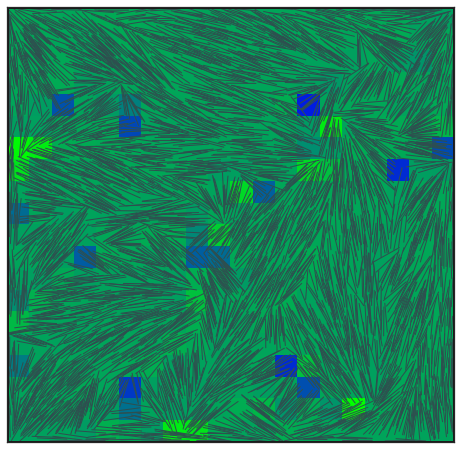

In [198]:
# Probe image
isnap = 0

f, ax = plt.subplots(1,1,figsize=(8,8))
radius = 0.5*edge
boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2,linewidth=3);
ax.add_artist(boundary);
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

probeimg = probecolors[isnap].reshape((nx,nx,3))
ax.imshow(probeimg,aspect="auto",extent=(-edge/2,edge/2,-edge/2,edge/2))

# Rods
for i,rod in enumerate(pltrods[isnap]):
    plotrods([rod],ax,col="darkslategrey",lw=1.)

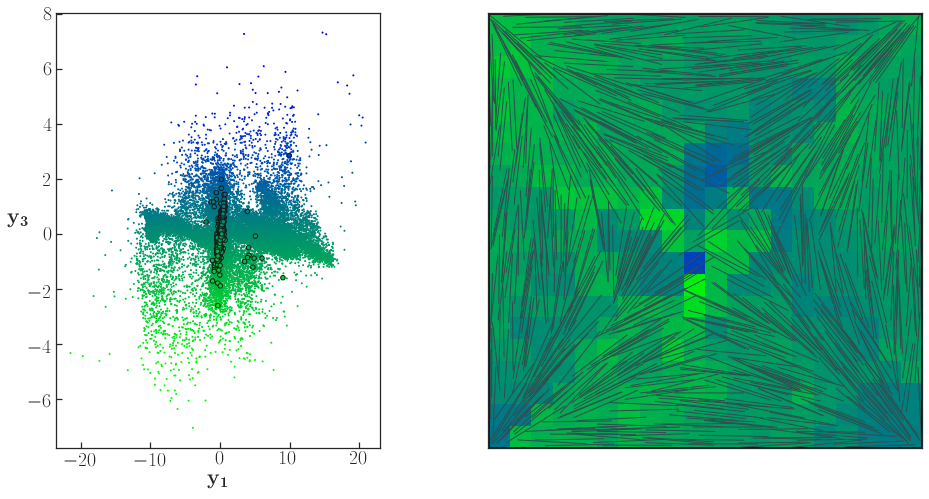

In [97]:
f, ax = plt.subplots(1,2,figsize=(16,8), gridspec_kw={'width_ratios': [1, 1.5]})

d = 1
if use_1D and Dim > 0:
    d = Dim

yx_, yy_ = 0, d
    
_ = ax[0].scatter(Y[::mev,yx_],Y[::mev,d],s=1,c=base_colors[::mev])
_ = ax[0].scatter(pca_feats[:,yx_],pca_feats[:,d],s=20,c=probecolors,edgecolors='k',linewidths=1)
ax[0].set_xlabel(r'$\mathbf{y_%d}$'%(yx_+1))
ax[0].set_ylabel(r'$\mathbf{y_%d}$'%(yy_+1),rotation="horizontal",labelpad=10)

# Plot rods as background
if not latticemode:
    for i,rod in enumerate(rods):
        plotrods([rod],ax[1],col=probecolors[i],lw=3.0) 
else:
    # Probe image
    # Your gen_probe function is set that with the transformation below
    # and how imshow plots that things are correct. You can verify
    # with the scatterplot that is commented
    probeimg = probecolors.copy()
    probeimg = probeimg.reshape((nx,nx,3))
    ax[1].imshow(probeimg,aspect="auto",extent=(-edge/2,edge/2,-edge/2,edge/2))

    # Rods
    for i,rod in enumerate(rods):
        plotrods([rod],ax[1],col="darkslategrey",lw=1.)

radius = 0.5*edge
# ax[1].set_xticks([])
# ax[1].set_yticks([])
boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2,linewidth=3);
ax[1].add_artist(boundary);
# ax[1].axis('off');
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[1].axis([-radius,radius,-radius,radius])
ax[1].set_aspect("equal")